Imports


In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
uploaded = files.upload()

df = pd.read_csv((list(uploaded.keys())[0] ))

Saving 0day _In the Wild_ - All.csv to 0day _In the Wild_ - All.csv


In [3]:
df.head()


,CVE,Vendor,Product,Type,Description,Date Discovered,Date Patched,Advisory,Analysis URL,Root Cause Analysis,Reported By
0,CVE-2024-23296,Apple,iOS,Memory Corruption,Arbitrary kernel r/w in RTKit,NaN,2024-03-06,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
1,CVE-2024-23225,Apple,iOS,Memory Corruption,Out-of-bounds memory access in Kernel,NaN,2024-03-05,https://support.apple.com/en-gb/HT214081,NaN,NaN,NaN
2,CVE-2024-23222,Apple,WebKit,Memory Corruption,Type confusion,NaN,2024-01-22,https://support.apple.com/en-us/HT214059,NaN,NaN,NaN
3,CVE-2024-0519,Google,Chrome,Memory Corruption,Out-of-bounds memory access,2024-01-11,2024-01-16,https://chromereleases.googleblog.com/2024/01/...,NaN,NaN,NaN
4,CVE-2023-7024,Google,Chrome,Memory Corruption,Heap overflow in WebRTC,2023-12-19,2023-12-20,https://chromereleases.googleblog.com/2023/12/...,NaN,NaN,Clément Lecigne and Vlad Stolyarov of Google's...


Top 10 most Zero-Day according to Companies.

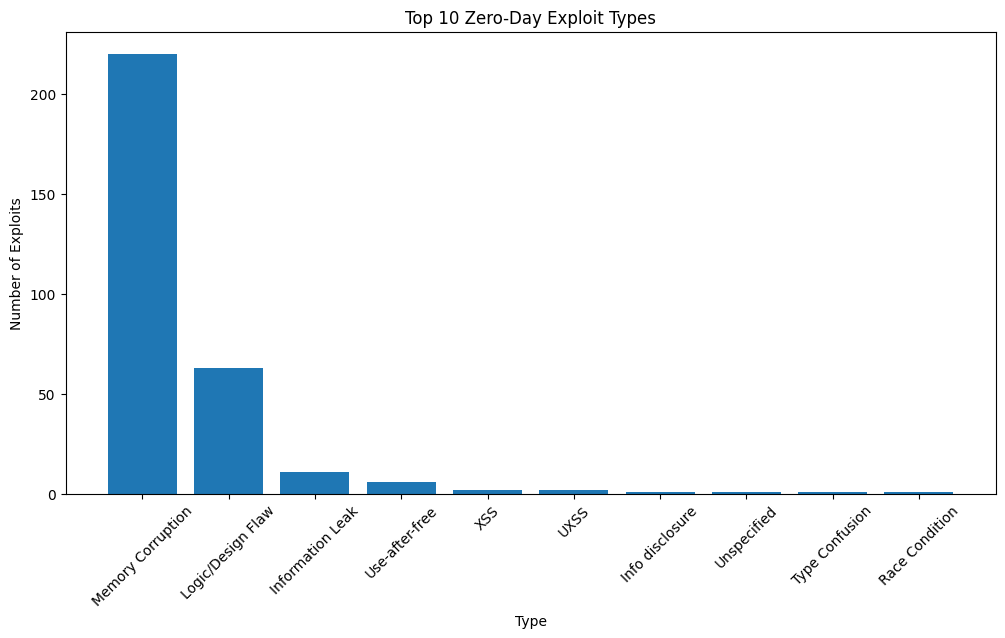

In [4]:

values = df['Type'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(values[:10].index, values[:10])
plt.xlabel('Type')
plt.ylabel('Number of Exploits')
plt.xticks(rotation=45)
plt.title('Top 10 Zero-Day Exploit Types')
plt.show()

The types of Zero-Day Exploitation.

In [5]:
df['Type'].value_counts()


Type
Memory Corruption    220
Logic/Design Flaw     63
Information Leak      11
Use-after-free         6
XSS                    2
UXSS                   2
Info disclosure        1
Unspecified            1
Type Confusion         1
Race Condition         1
Name: count, dtype: int64

Classification based on the Exploitation type.


In [6]:
df['Date Discovered'].fillna('Unknown', inplace=True)
df['Root Cause Analysis'].fillna('Unknown', inplace=True)
df['Analysis URL'].fillna('Unknown', inplace=True)
df['Type'].fillna('Unknown', inplace=True)


In [7]:
le = LabelEncoder()
for column in ['CVE', 'Type', 'Vendor', 'Product', 'Description', 'Date Patched', 'Advisory']:
    df[column] = le.fit_transform(df[column])


In [8]:
X = df[['CVE', 'Vendor', 'Product', 'Description', 'Date Discovered',
       'Date Patched', 'Advisory', 'Analysis URL', 'Root Cause Analysis']]
y = df['Type']

for column in ['Date Discovered','Analysis URL', 'Root Cause Analysis']:
  X[column] = le.fit_transform(X[column])

scaler = StandardScaler()
X = scaler.fit_transform(X)


<ipython-input-8-381656fd920c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-8-381656fd920c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-8-381656fd920c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
df['Type']

0      3
1      3
2      3
3      3
4      3
      ..
307    3
308    3
309    3
310    2
311    2
Name: Type, Length: 312, dtype: int64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Building the Model

In [10]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(y.unique()), activation='softmax')
])

Compiling the Model.

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


Training the model

In [15]:
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/15
7/7 [==============================] - 0s 67ms/step - loss: 0.7744 - accuracy: 0.7286 - val_loss: 0.9936 - val_accuracy: 0.7400
Epoch 2/15
7/7 [==============================] - 0s 34ms/step - loss: 0.7431 - accuracy: 0.7487 - val_loss: 0.9986 - val_accuracy: 0.7200
Epoch 3/15
7/7 [==============================] - 0s 17ms/step - loss: 0.7982 - accuracy: 0.7236 - val_loss: 1.0017 - val_accuracy: 0.7000
Epoch 4/15
7/7 [==============================] - 0s 25ms/step - loss: 0.7759 - accuracy: 0.7286 - val_loss: 0.9971 - val_accuracy: 0.7400
Epoch 5/15
7/7 [==============================] - 0s 27ms/step - loss: 0.7833 - accuracy: 0.7085 - val_loss: 1.0012 - val_accuracy: 0.7400
Epoch 6/15
7/7 [==============================] - 0s 32ms/step - loss: 0.7417 - accuracy: 0.7085 - val_loss: 1.0062 - val_accuracy: 0.7400
Epoch 7/15
7/7 [==============================] - 0s 34ms/step - loss: 0.7627 - accuracy: 0.7236 - val_loss: 1.0103 - val_accuracy: 0.7400
Epoch 8/15
7/7 [===========

Making predictions

In [21]:
predictions = model.predict(X_test)
predicted_classes = tf.argmax(predictions, axis=1)

predicted_classes

2/2 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(63,), dtype=int64, numpy=
array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])>

Confusion Matrix

In [22]:
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(f'Confusion Matrix:\n{conf_matrix}')


Confusion Matrix:
[[ 0  0  3  0  0  0]
 [ 0  6  8  0  0  0]
 [ 0  2 40  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  1  0  0  0  0]]


In [23]:
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

# Classification Report
class_report = classification_report(y_test, predicted_classes)
print(f'Classification Report:\n{class_report}')

Accuracy: 0.7301587301587301
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.67      0.43      0.52        14
           3       0.74      0.95      0.83        42
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1

    accuracy                           0.73        63
   macro avg       0.23      0.23      0.23        63
weighted avg       0.64      0.73      0.67        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting the Confusion Matrix

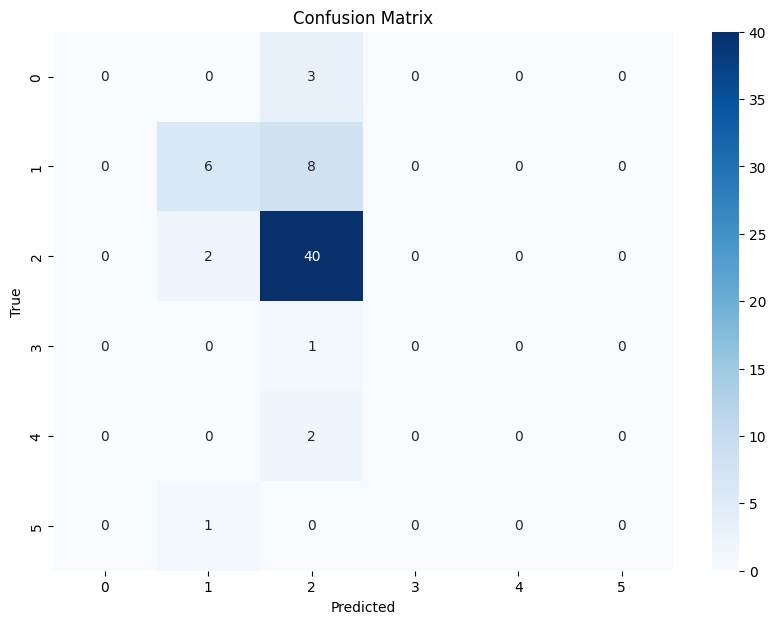

In [24]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
